In [41]:
from helpers import get_sample
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from tabulate import tabulate

models = [
    # Biophysical models
    'gagge',
    'ji',
    'takahashi',
    # ML models
    'ml_ridge_regression',
    'ml_linear_regression',
    'ml_neural_network',
    'ml_decision_tree',
    'ml_lasso_regression',
    'ml_random_forest',
    'ml_bagging_regression',
    'rnn'
]

studies = [
    'heatwave 1 (prolonged)',
    'heatwave 2 (indoor)',
    'heatwave 3 (cooling)'
]

conditions = [
    'cool',
    'temp',
    'warm',
    'hot'
]

test_ids = [61, 97, 50, 83, 81, 75, 96, 36, 72, 62, 27, 84, 63, 69, 79, 42, 92,
            88, 33, 55, 64, 54, 93, 45, 29, 47, 48, 38, 57, 90, 41]

In [42]:
# COMPILE DATASET

# List of samples, each item is a dataframe for that particular experiment
# The dataframe contains the dataset, as well as the predicted values
samples = []

for study in studies:
    for condition in conditions:
        sample = get_sample(study, condition)
        # Drop index
        sample = sample.reset_index(drop=True)
        if (sample.shape[0] > 0):
            # Sample exists
            for model in models:
                try:
                    predicted = pd.read_csv('./results/{}-{}-{}.csv'.format(model, study, condition), header=0, names=['tre_predicted', 'mtsk_predicted'])
                    if predicted['tre_predicted'].dtype != 'float64':
                        print('./results/{}-{}-{}.csv tre_predicted needs to be cast to numeric'.format(model, study, condition))
                        predicted['tre_predicted'] = pd.to_numeric(predicted['tre_predicted'], errors='coerce')
                    if predicted['mtsk_predicted'].dtype != 'float64':
                        print('./results/{}-{}-{}.csv mtsk_predicted needs to be cast to numeric'.format(model, study, condition))
                        predicted['mtsk_predicted'] = pd.to_numeric(predicted['mtsk_predicted'], errors='coerce')
                    # Rename columns
                    tre_columm = 'tre_predicted_{}'.format(model)
                    mtsk_columm = 'mtsk_predicted_{}'.format(model)
                    predicted.rename(columns={'tre_predicted': tre_columm, 'mtsk_predicted': mtsk_columm}, inplace=True)
                    # Concat prediction to dataframe
                    sample = pd.concat([sample, predicted], axis=1)
                except:
                    print("File not found:", './results/{}-{}-{}.csv'.format(model, study, condition))
            # Remove any IDs that don't appear in test_ids
            sample = sample[sample['id_all'].isin(test_ids)]
            # Save sample to compiled results
            sample.to_csv('results_compiled/{}-{}.csv'.format(study,condition))
            samples.append(sample)

In [43]:
# Merge all samples together
merged_samples = pd.concat(samples, ignore_index=True)

# Define an empty list to store results
results = []

# Calculate RMSE for each model
for model in models:
    tre_col = 'tre_predicted_{}'.format(model)
    mtsk_col = 'mtsk_predicted_{}'.format(model)

    if tre_col in merged_samples.columns and mtsk_col in merged_samples.columns:
        # Calculate and round RMSE for tre
        tre_rmse = round(np.sqrt(mean_squared_error(merged_samples[tre_col], merged_samples['tre_int'])), 2)

        # Calculate and round RMSE for mtsk
        mtsk_rmse = round(np.sqrt(mean_squared_error(merged_samples[mtsk_col], merged_samples['mtsk_int'])), 2)

        # Calculate mean RMSE
        mean_rmse = round((tre_rmse + mtsk_rmse) / 2, 2)

        # Append results to list
        results.append([model, tre_rmse, mtsk_rmse, mean_rmse])
    else:
        print(f"Columns for model {model} not found in the merged data.")

# Convert the results list to DataFrame for better visualization and compatibility with tabulate
results_df = pd.DataFrame(results, columns=['Model', 'tre_RMSE', 'mtsk_RMSE', 'Mean_RMSE'])

# Convert the DataFrame to LaTeX table
latex_table = tabulate(results_df, tablefmt="latex", headers="keys", showindex=False)

print(latex_table)


\begin{tabular}{lrrr}
\hline
 Model                 &   tre\_RMSE &   mtsk\_RMSE &   Mean\_RMSE \\
\hline
 gagge                 &       0.58 &        0.87 &        0.72 \\
 ji                    &       0.41 &        1.89 &        1.15 \\
 takahashi             &       0.45 &        1.18 &        0.82 \\
 ml\_ridge\_regression   &       0.29 &        0.8  &        0.55 \\
 ml\_linear\_regression  &       0.3  &        0.86 &        0.58 \\
 ml\_neural\_network     &       0.68 &        1.45 &        1.06 \\
 ml\_decision\_tree      &       0.55 &        1.72 &        1.14 \\
 ml\_lasso\_regression   &       0.49 &        1.85 &        1.17 \\
 ml\_random\_forest      &       0.59 &        2.1  &        1.34 \\
 ml\_bagging\_regression &       0.59 &        3.08 &        1.84 \\
 rnn                   &       0.43 &        1.37 &        0.9  \\
\hline
\end{tabular}


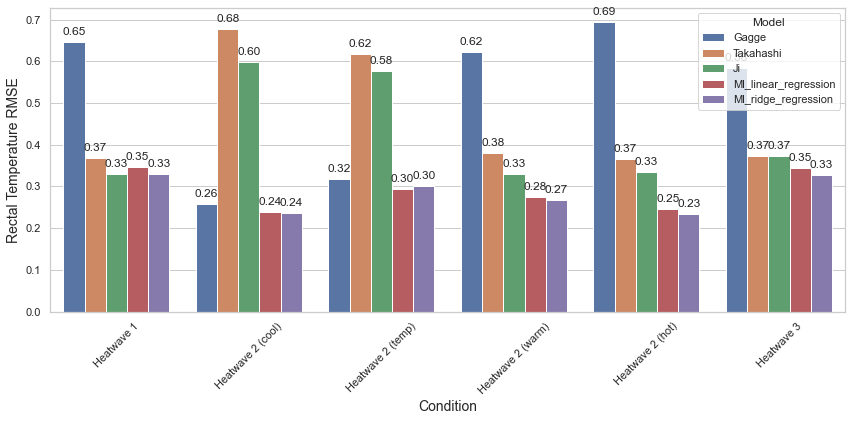

In [59]:
models = [
    # Biophysical models
    'gagge',
    'ji',
    'takahashi',
    # ML models
    'ml_ridge_regression',
    'ml_linear_regression',
]

# To store the MSE of each model for each condition
rmse_dict = {}

# Loop over each sample DataFrame
for sample_idx, sample in enumerate(samples):
    study = sample.study.iloc[0]
    condition = sample.condition.iloc[0]

    # For each model, calculate the MSE and store it
    for model in models:
        model_column = 'tre_predicted_{}'.format(model)
        if model_column in sample.columns:
            mse = mean_squared_error(sample.tre_int, sample[model_column])
            rmse = sqrt(mse)
            # Store the MSE in the dictionary
            rmse_dict[(study, condition, model)] = rmse
        else:
            print(f"Column {model_column} not found in {study} {condition} dataframe.")

# Set the style and increase the size of the plot
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Convert the dictionary to a DataFrame
df = pd.DataFrame(list(rmse_dict.items()), columns=['Key', 'RMSE'])
df[['Study', 'Condition', 'Model']] = pd.DataFrame(df['Key'].tolist(), index=df.index)
df = df.drop(columns='Key')

# Capitalize the first letter of each model
df['Model'] = df['Model'].str.capitalize()

# Create a new column that combines 'Study' and 'Condition'
df['StudyCondition'] = df['Study'] + ' - ' + df['Condition']

# Remap labels
remap_dict = {
    'heatwave 1 (prolonged) - hot': 'Heatwave 1',
    'heatwave 2 (indoor) - cool': 'Heatwave 2 (cool)',
    'heatwave 2 (indoor) - temp': 'Heatwave 2 (temp)',
    'heatwave 2 (indoor) - warm': 'Heatwave 2 (warm)',
    'heatwave 2 (indoor) - hot': 'Heatwave 2 (hot)',
    'heatwave 3 (cooling) - hot': 'Heatwave 3',
}

df['StudyCondition'] = df['StudyCondition'].replace(remap_dict)

# Melt the DataFrame back to long format for seaborn
df_melt = df.melt(id_vars=['StudyCondition', 'Model'], value_vars='RMSE')

# Calculate the average MSE for each Model
avg_mse = df.groupby('Model')['RMSE'].mean().sort_values(ascending=False)

# Sort the 'Model' category based on the average MSE
df_melt['Model'] = df_melt['Model'].astype('category')
df_melt['Model'] = df_melt['Model'].cat.set_categories(avg_mse.index)

# Plot the grouped bar chart
ax = sns.barplot(x='StudyCondition', y='value', hue='Model', data=df_melt, hue_order=avg_mse.index)

# Add a value label to each bar
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

# plt.title('RMSE of Each Model Over Every Condition', fontsize=16)
plt.ylabel('Rectal Temperature RMSE', fontsize=14)
plt.xlabel('Condition', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
# Save figure
plt.savefig("figures/rectal_rmse_chart.pdf", format='pdf')
plt.show()

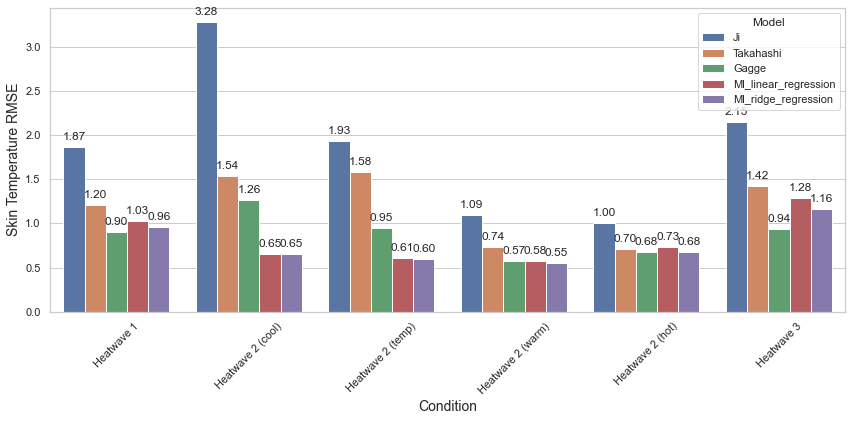

In [15]:
# To store the MSE of each model for each condition
rmse_dict = {}

# Loop over each sample DataFrame
for sample_idx, sample in enumerate(samples):
    study = sample.study.iloc[0]
    condition = sample.condition.iloc[0]

    # For each model, calculate the MSE and store it
    for model in models:
        model_column = 'mtsk_predicted_{}'.format(model)
        if model_column in sample.columns:
            mse = mean_squared_error(sample.mtsk_int, sample[model_column])
            rmse = sqrt(mse)
            # Store the MSE in the dictionary
            rmse_dict[(study, condition, model)] = rmse
        else:
            print(f"Column {model_column} not found in {study} {condition} dataframe.")

# Set the style and increase the size of the plot
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Convert the dictionary to a DataFrame
df = pd.DataFrame(list(rmse_dict.items()), columns=['Key', 'RMSE'])
df[['Study', 'Condition', 'Model']] = pd.DataFrame(df['Key'].tolist(), index=df.index)
df = df.drop(columns='Key')

# Capitalize the first letter of each model
df['Model'] = df['Model'].str.capitalize()

# Create a new column that combines 'Study' and 'Condition'
df['StudyCondition'] = df['Study'] + ' - ' + df['Condition']

# Remap labels
remap_dict = {
    'heatwave 1 (prolonged) - hot': 'Heatwave 1',
    'heatwave 2 (indoor) - cool': 'Heatwave 2 (cool)',
    'heatwave 2 (indoor) - temp': 'Heatwave 2 (temp)',
    'heatwave 2 (indoor) - warm': 'Heatwave 2 (warm)',
    'heatwave 2 (indoor) - hot': 'Heatwave 2 (hot)',
    'heatwave 3 (cooling) - hot': 'Heatwave 3',
}

df['StudyCondition'] = df['StudyCondition'].replace(remap_dict)

# Melt the DataFrame back to long format for seaborn
df_melt = df.melt(id_vars=['StudyCondition', 'Model'], value_vars='RMSE')

# Calculate the average MSE for each Model
avg_mse = df.groupby('Model')['RMSE'].mean().sort_values(ascending=False)

# Sort the 'Model' category based on the average MSE
df_melt['Model'] = df_melt['Model'].astype('category')
df_melt['Model'] = df_melt['Model'].cat.set_categories(avg_mse.index)

# Plot the grouped bar chart
ax = sns.barplot(x='StudyCondition', y='value', hue='Model', data=df_melt, hue_order=avg_mse.index)

# Add a value label to each bar
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

# plt.title('RMSE of Each Model Over Every Condition', fontsize=16)
plt.ylabel('Skin Temperature RMSE', fontsize=14)
plt.xlabel('Condition', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
# Save figure
plt.savefig("figures/skin_rmse_chart.pdf", format='pdf')
plt.show()

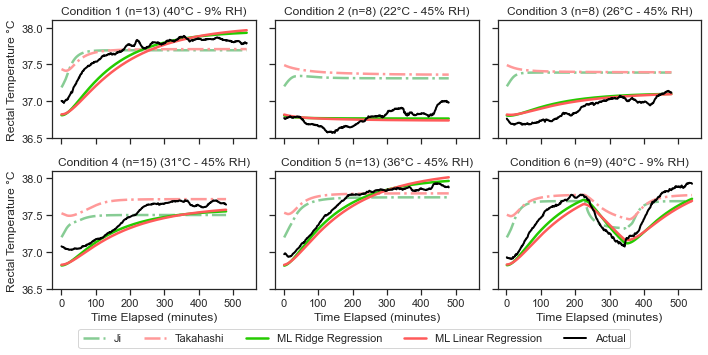

In [60]:
models = [
    # Biophysical models
    'ji', 'takahashi',
    # ML models
    'ml_ridge_regression', 'ml_linear_regression',
]

sns.set(style="ticks")
sns.set_palette(sns.color_palette(['#87CC94', '#FF9999', '#25CB00', '#FF5A5A']))

import matplotlib.pyplot as plt
import numpy as np

# Create the figure and the subplots.
# Modify rows and columns parameters as per your requirement. Here, it's assuming a 2x2 grid.
rows, cols = 2, 3
fig, axs = plt.subplots(rows, cols, figsize=(10, 5), sharex=True, sharey=True)

# Flattening the axes array to make iterating easier
axs = axs.flatten()

# Create empty lists to store the line handles and labels
handles = []
labels = ["Ji", "Takahashi", "ML Ridge Regression", "ML Linear Regression", "Actual"]

# Loop over each sample DataFrame
for idx, sample in enumerate(samples):
    study = sample.study.iloc[0]
    condition = sample.condition.iloc[0]

    # Filter by age
    sample = sample[sample.age >= 60]

    # Group by 'time'
    sample_grouped = sample.groupby('time').mean()

    # Plotting the predicted data
    for model in models:
        model_column = 'tre_predicted_{}'.format(model)
        if model_column in sample_grouped.columns:
            if 'ml_' in model:
                line, = axs[idx].plot(sample_grouped.index, sample_grouped[model_column], linewidth=2.5, linestyle="-")
            else:
                line, = axs[idx].plot(sample_grouped.index, sample_grouped[model_column], linewidth=2.5, linestyle="-.")

            # Append the line handle and label to the lists
            if idx == 0:
                handles.append(line)
        else:
            print(f"Column {model_column} not found in {study} {condition} dataframe.")

    # Plotting the actual data
    line, = axs[idx].plot(sample_grouped.index, sample_grouped.tre_int, linewidth=2, color="black")
    if idx == 0:
        handles.append(line)

    # Setting title, limits and labels
    axs[idx].set_title('Condition {} (n={}) ({}°C - {}% RH)'.format(
        idx+1, len(sample.id_all.unique()), sample.ta_set.iloc[0], sample.rh_set.iloc[0]
    ))
    axs[idx].set_ylim(36.5, 38.1)
    # Remove y-axis labels except for the far left two subplots
    if idx % cols != 0:
        axs[idx].set_ylabel("")
    else:
        axs[idx].set_ylabel("Rectal Temperature °C")

    # Remove x-axis labels except for the bottom three subplots
    if idx < (rows - 1) * cols:
        axs[idx].set_xlabel("")
    else:
        axs[idx].set_xlabel("Time Elapsed (minutes)")

# Handling unused subplots
for idx_unused in range(len(samples), rows*cols):
    fig.delaxes(axs[idx_unused])

# Create a single legend using the handles and labels from the first subplot
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0), ncol=5)

# Adjust layout for better visualization
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust the rect parameter to make space for the legend

# Save figure with higher DPI
plt.savefig("figures/rectal_line_chart.pdf", format='pdf', dpi=300)

# Show the plot
plt.show()

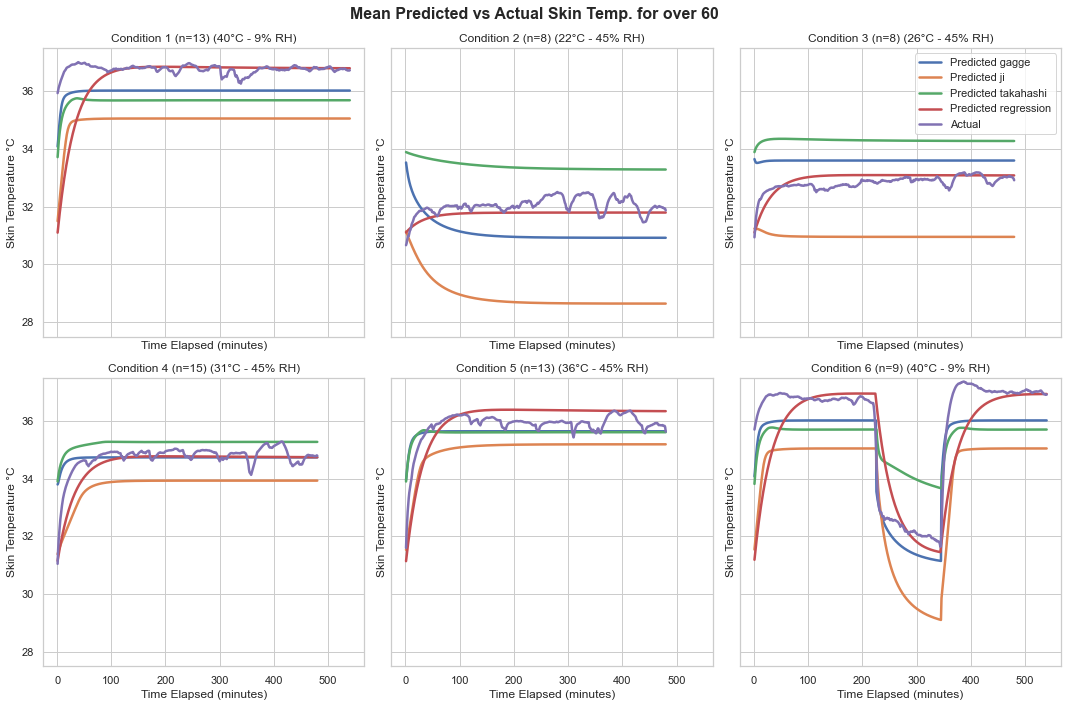

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Create the figure and the subplots.
# Modify rows and columns parameters as per your requirement. Here, it's assuming a 2x2 grid.
rows, cols = 2, int(np.ceil(len(samples) / 2))
fig, axs = plt.subplots(rows, cols, figsize=(15, 10), sharex=True, sharey=True)

# Title
fig.suptitle('Mean Predicted vs Actual Skin Temp. for over 60', fontsize=16, fontweight='bold')

# Flattening the axes array to make iterating easier
axs = axs.flatten()

# Loop over each sample DataFrame
for idx, sample in enumerate(samples):
    study = sample.study.iloc[0]
    condition = sample.condition.iloc[0]
    # Filter by age
    sample = sample[sample.age >= 60]
    # Group by 'time'
    sample_grouped = sample.groupby('time').mean()

    # Plotting the predicted data
    for model in models:
        model_column = 'mtsk_predicted_{}'.format(model)
        if model_column in sample_grouped.columns:
            axs[idx].plot(sample_grouped.index, sample_grouped[model_column], label="Predicted {}".format(model), linewidth=2.5)
        else:
            print(f"Column {model_column} not found in {study} {condition} dataframe.")

    # Plotting the actual data
    axs[idx].plot(sample_grouped.index, sample_grouped.mtsk_int, label="Actual", linewidth=2.5)

    # Setting title, limits and labels
    axs[idx].set_title('Condition {} (n={}) ({}°C - {}% RH)'.format(
        idx+1,
        len(sample.id_all.unique()),
        sample.ta_set.iloc[0],
        sample.rh_set.iloc[0]
    ))
    axs[idx].set_ylim(27.5, 37.5)
    axs[idx].set_ylabel("Skin Temperature °C")
    axs[idx].set_xlabel("Time Elapsed (minutes)")

# Handling unused subplots
for idx_unused in range(len(samples), rows*cols):
    fig.delaxes(axs[idx_unused])

# Displaying the legend
axs[2].legend(loc="upper right")

# Adjust layout for better visualization
plt.tight_layout()

# Save figure
plt.savefig("figures/skin_line_chart.pdf", format='pdf')
# Show the plot
plt.show()
